What health features most closely correspond with alzheimers

In [1]:
# Import dependencies
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
import pandas as pd
import pyspark
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from pyspark.shell import spark
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)


c:\Users\Phil\anaconda3\envs\dev\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.1
      /_/

Using Python version 3.10.13 (main, Sep 11 2023 13:24:38)
Spark context Web UI available at http://DESKTOP-DBH5AIK.mynetworksettings.com:4040
Spark context available as 'sc' (master = local[*], app id = local-1719525857900).
SparkSession available as 'spark'.


In [2]:
#Assign path to variable
alzheimer_data_path = "Data/alzheimers_disease_data.csv"

In [8]:
#Create temp view to be able to easily query from DataFrame
spark_test_df = spark.read.csv(alzheimer_data_path, header = 'True', inferSchema=True)
data = spark_test_df.toPandas()

In [9]:
# Drop the Doctor in Charge, As it is confiential data only 'XXXX' is a value
data.drop(['DoctorInCharge'],axis=1, inplace=True)

In [10]:
# Dictonaries of replacement data for Medical History
Gender_Dict = {0:'Male', 1:'Female'}
Ethnicity_Dict = {0:'Caucasian', 1:'African American', 2:'Asian', 3:'Other'}
Education_Dict = {0:"None", 1:"High School", 2:"Bachelor's", 3: "Higher"}
Smoking_Dict = {0:'Non-Smoker', 1:'Smoker'}
FamilyHistoryAlzheimers_Dict = {0:'No Alzheimers in Family',1:'Alzheimers in Family'}
CardiovascularDisease_Dict = {0:'No Cardiovascular', 1:'Cardiovascular'}
Diabetes_Dict = {0:'No Diabetes', 1:'Diabetes'}
Depression_Dict = {0:'No Depression', 1:'Depression'}
HeadInjury_Dict = {0:'No History of Head Injury', 1: 'History of Head Injury'} 
Hypertension_Dict = {0:'Non-hypertensive', 1: 'Hypertensive'} 

In [16]:
# Replaceing of Data for Medical History
data['Gender'].replace(to_replace=Gender_Dict,inplace=True)
data['Ethnicity'].replace(to_replace=Ethnicity_Dict,inplace=True)
data['EducationLevel'].replace(to_replace=Education_Dict,inplace=True)
data['Smoking'].replace(to_replace=Smoking_Dict,inplace=True)
data['FamilyHistoryAlzheimers'].replace(to_replace=FamilyHistoryAlzheimers_Dict,inplace=True)
data['CardiovascularDisease'].replace(to_replace=CardiovascularDisease_Dict,inplace=True)
data['Diabetes'].replace(to_replace=Diabetes_Dict,inplace=True)
data['Depression'].replace(to_replace=Depression_Dict,inplace=True)
data['HeadInjury'].replace(to_replace=HeadInjury_Dict,inplace=True)
data['Hypertension'].replace(to_replace=Hypertension_Dict,inplace=True)

data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,Male,Caucasian,Bachelor's,22.927749,Non-Smoker,13.297218,6.327112,1.347214,9.025679,No Alzheimers in Family,No Cardiovascular,Diabetes,Depression,No History of Head Injury,Non-hypertensive,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,No Memory Issues,No Behavioral Issues,1.725883,Not Confused,Not Disoriented,No Personality Changes,Difficulty,Not forgetful,0
1,4752,89,Male,Caucasian,None,26.827681,Non-Smoker,4.542524,7.619885,0.518767,7.151293,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,No Memory Issues,No Behavioral Issues,2.592424,Not Confused,Not Disoriented,No Personality Changes,No Difficulty,Forgetful,0
2,4753,73,Male,Other,High School,17.795882,Non-Smoker,19.555085,7.844988,1.826335,9.673574,Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,No Memory Issues,No Behavioral Issues,7.119548,Not Confused,Disoriented,No Personality Changes,Difficulty,Not forgetful,0
3,4754,74,Female,Caucasian,High School,33.800817,Smoker,12.209266,8.428001,7.435604,8.392554,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,No Memory Issues,Behavioral Issues,6.481226,Not Confused,Not Disoriented,No Personality Changes,No Difficulty,Not forgetful,0
4,4755,89,Male,Caucasian,None,20.716974,Non-Smoker,18.454356,6.310461,0.795498,5.597238,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,No Memory Issues,No Behavioral Issues,0.014691,Not Confused,Not Disoriented,Personality Changes,Difficulty,Not forgetful,0


In [12]:
# Dictonaries of replacement data for Cognitive and Functional Assessments

MemoryComplaints_Dict = {0:'No Memory Issues', 1:'Memory Complains'}
BehavioralProblems_Dict = {0:'No Behavioral Issues', 1:'Behavioral Issues'}

In [13]:
# Replaceing of Data for Cognitive and Functional Assessments
data['MemoryComplaints'].replace(to_replace=MemoryComplaints_Dict, inplace=True)
data['BehavioralProblems'].replace(to_replace=BehavioralProblems_Dict, inplace=True)

data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,Male,Caucasian,Bachelor's,22.927749,Non-Smoker,13.297218,6.327112,1.347214,9.025679,No Alzheimers in Family,No Cardiovascular,Diabetes,Depression,No History of Head Injury,Non-hypertensive,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,No Memory Issues,No Behavioral Issues,1.725883,0,0,0,1,0,0
1,4752,89,Male,Caucasian,None,26.827681,Non-Smoker,4.542524,7.619885,0.518767,7.151293,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,No Memory Issues,No Behavioral Issues,2.592424,0,0,0,0,1,0
2,4753,73,Male,Other,High School,17.795882,Non-Smoker,19.555085,7.844988,1.826335,9.673574,Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,No Memory Issues,No Behavioral Issues,7.119548,0,1,0,1,0,0
3,4754,74,Female,Caucasian,High School,33.800817,Smoker,12.209266,8.428001,7.435604,8.392554,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,No Memory Issues,Behavioral Issues,6.481226,0,0,0,0,0,0
4,4755,89,Male,Caucasian,None,20.716974,Non-Smoker,18.454356,6.310461,0.795498,5.597238,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,No Memory Issues,No Behavioral Issues,0.014691,0,0,1,1,0,0


In [14]:
# Dictonaries of replacement data for Symptoms

Confusion_Dict = {0: 'Not Confused', 1: 'Confused'}
Disorientation_Dict = {0: 'Not Disoriented', 1: 'Disoriented'}
PersonalityChanges_Dict = {0: 'No Personality Changes', 1: 'Personality Changes'}
DifficultyCompletingTasks_Dict = {0: 'No Difficulty', 1: 'Difficulty'}
Forgetfulness_Dict = {0: 'Not forgetful', 1: 'Forgetful'}

In [15]:
# Replaceing of Data for Symptoms
data['Confusion'].replace(to_replace=Confusion_Dict, inplace=True)
data['Disorientation'].replace(to_replace=Disorientation_Dict, inplace=True)
data['PersonalityChanges'].replace(to_replace=PersonalityChanges_Dict, inplace=True)
data['DifficultyCompletingTasks'].replace(to_replace=DifficultyCompletingTasks_Dict, inplace=True)
data['Forgetfulness'].replace(to_replace=Forgetfulness_Dict, inplace=True)

data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,Male,Caucasian,Bachelor's,22.927749,Non-Smoker,13.297218,6.327112,1.347214,9.025679,No Alzheimers in Family,No Cardiovascular,Diabetes,Depression,No History of Head Injury,Non-hypertensive,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,No Memory Issues,No Behavioral Issues,1.725883,Not Confused,Not Disoriented,No Personality Changes,Difficulty,Not forgetful,0
1,4752,89,Male,Caucasian,None,26.827681,Non-Smoker,4.542524,7.619885,0.518767,7.151293,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,No Memory Issues,No Behavioral Issues,2.592424,Not Confused,Not Disoriented,No Personality Changes,No Difficulty,Forgetful,0
2,4753,73,Male,Other,High School,17.795882,Non-Smoker,19.555085,7.844988,1.826335,9.673574,Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,No Memory Issues,No Behavioral Issues,7.119548,Not Confused,Disoriented,No Personality Changes,Difficulty,Not forgetful,0
3,4754,74,Female,Caucasian,High School,33.800817,Smoker,12.209266,8.428001,7.435604,8.392554,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,No Memory Issues,Behavioral Issues,6.481226,Not Confused,Not Disoriented,No Personality Changes,No Difficulty,Not forgetful,0
4,4755,89,Male,Caucasian,None,20.716974,Non-Smoker,18.454356,6.310461,0.795498,5.597238,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,No Memory Issues,No Behavioral Issues,0.014691,Not Confused,Not Disoriented,Personality Changes,Difficulty,Not forgetful,0


In [17]:
Diagnosis_Dict = {0: "No Alzheimer's Disease", 1: "Alzheimer's Disease"}

data['Diagnosis'].replace(to_replace=Diagnosis_Dict, inplace=True)

data.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,Male,Caucasian,Bachelor's,22.927749,Non-Smoker,13.297218,6.327112,1.347214,9.025679,No Alzheimers in Family,No Cardiovascular,Diabetes,Depression,No History of Head Injury,Non-hypertensive,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,No Memory Issues,No Behavioral Issues,1.725883,Not Confused,Not Disoriented,No Personality Changes,Difficulty,Not forgetful,No Alzheimer's Disease
1,4752,89,Male,Caucasian,None,26.827681,Non-Smoker,4.542524,7.619885,0.518767,7.151293,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,No Memory Issues,No Behavioral Issues,2.592424,Not Confused,Not Disoriented,No Personality Changes,No Difficulty,Forgetful,No Alzheimer's Disease
2,4753,73,Male,Other,High School,17.795882,Non-Smoker,19.555085,7.844988,1.826335,9.673574,Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,No Memory Issues,No Behavioral Issues,7.119548,Not Confused,Disoriented,No Personality Changes,Difficulty,Not forgetful,No Alzheimer's Disease
3,4754,74,Female,Caucasian,High School,33.800817,Smoker,12.209266,8.428001,7.435604,8.392554,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,No Memory Issues,Behavioral Issues,6.481226,Not Confused,Not Disoriented,No Personality Changes,No Difficulty,Not forgetful,No Alzheimer's Disease
4,4755,89,Male,Caucasian,None,20.716974,Non-Smoker,18.454356,6.310461,0.795498,5.597238,No Alzheimers in Family,No Cardiovascular,No Diabetes,No Depression,No History of Head Injury,Non-hypertensive,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,No Memory Issues,No Behavioral Issues,0.014691,Not Confused,Not Disoriented,Personality Changes,Difficulty,Not forgetful,No Alzheimer's Disease


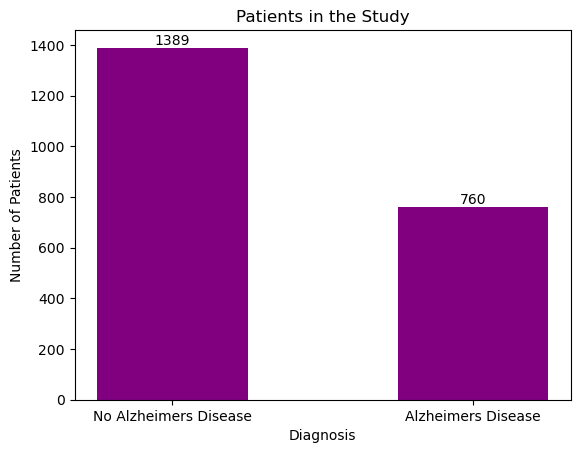

In [19]:
data['BMI'] = data['BMI'].astype('int')
values, bins, bars = plt.hist(data['Diagnosis'], bins = 2, rwidth= .5, color= 'purple')
plt.title('Patients in the Study')
plt.xticks(ticks= [.25, .75], labels=['No Alzheimer''s Disease','Alzheimer''s Disease'])
plt.xlabel('Diagnosis')
plt.ylabel('Number of Patients')
plt.bar_label(bars)
plt.show()

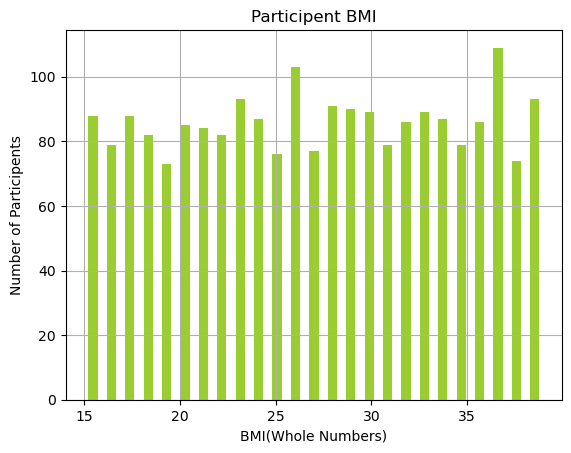

In [20]:
bins_BMI = data['BMI'].max() - data['BMI'].min()+1
data['BMI'].hist(bins=bins_BMI, histtype = 'bar', rwidth = .5, color = 'yellowgreen')
plt.xlabel('BMI(Whole Numbers)')
plt.ylabel('Number of Participents')
plt.title('Participent BMI')
plt.show()

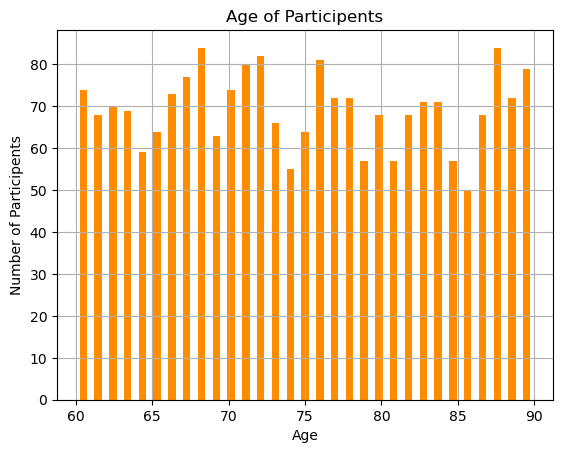

In [21]:
bins_Age = data['Age'].astype('int').max() - data['Age'].astype('int').min()+1
data['Age'].hist(bins=bins_Age, rwidth = .5, color = 'darkorange')
plt.xlabel('Age')
plt.ylabel('Number of Participents')
plt.title('Age of Participents')
plt.show()

<Axes: title={'center': 'Study Paticipents by Gender'}>

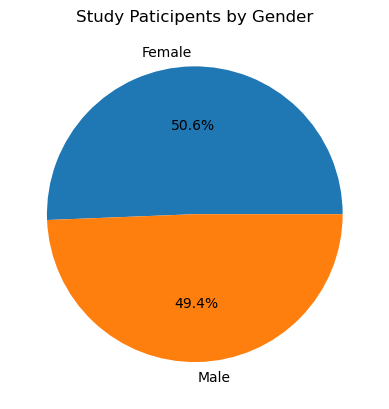

In [22]:
data.groupby('Gender')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by Gender',ylabel = "")

<Axes: title={'center': 'Study Paticipents by Ethnicity'}>

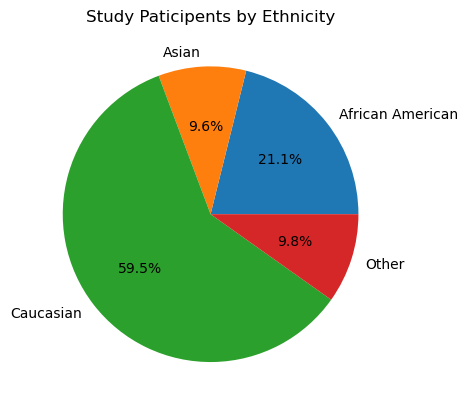

In [23]:
data.groupby('Ethnicity')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by Ethnicity',ylabel = "")

<Axes: title={'center': 'Study Paticipents by History'}>

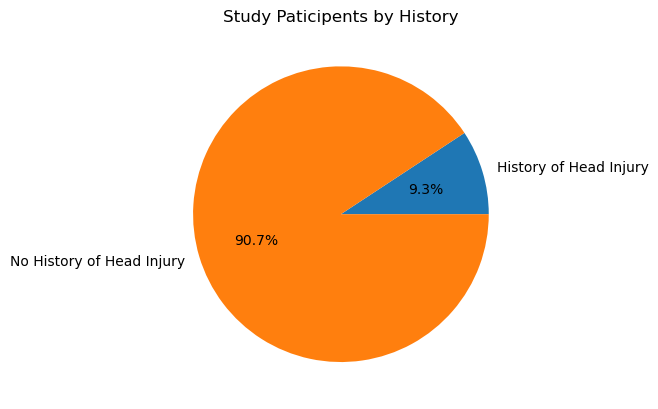

In [24]:
data.groupby('HeadInjury')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by History',ylabel = "")

<Axes: title={'center': 'Study Paticipents by History'}>

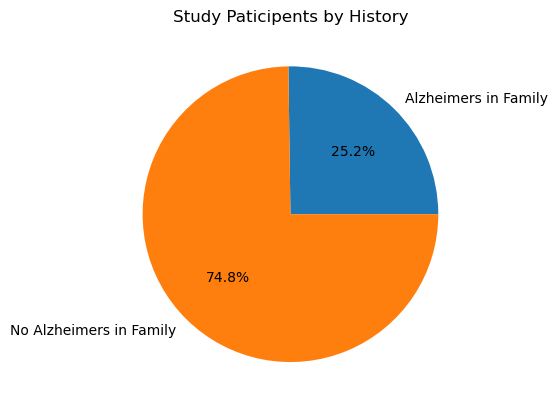

In [25]:
data.groupby('FamilyHistoryAlzheimers')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by History',ylabel = "")

<Axes: title={'center': 'Study Paticipents by Diagnosis'}>

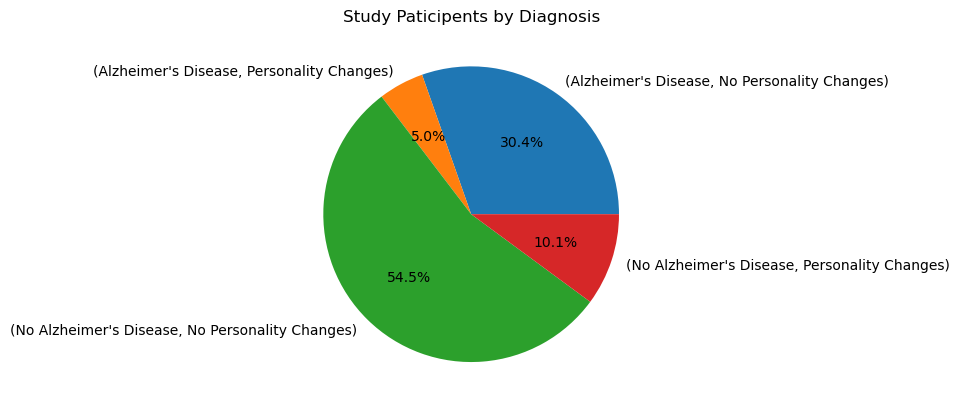

In [26]:
data.groupby(['Diagnosis','PersonalityChanges'])['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by Diagnosis',ylabel = "")

<Axes: title={'center': 'Study Paticipents by Diagnosis'}>

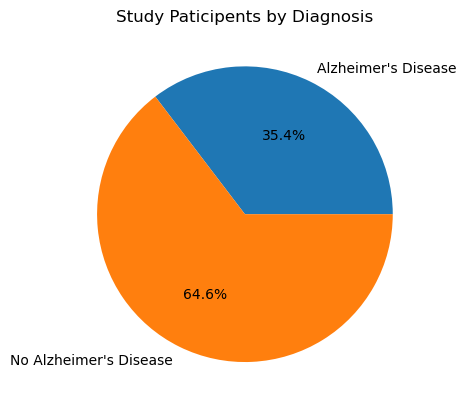

In [27]:
data.groupby('Diagnosis')['PatientID'].count().plot.pie(autopct='%1.1f%%', title = 'Study Paticipents by Diagnosis',ylabel = "")

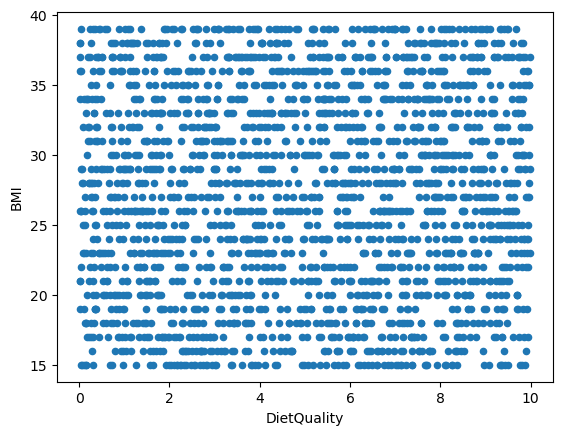

In [28]:
data.plot(kind='scatter', x= 'DietQuality', y='BMI')

plt.show()